# SSD Scratch Two

In [1]:
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import gluon
from mxnet import image
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (6,6)
import matplotlib.pyplot as plt

mx.random.seed(2018)
ctx = mx.cpu()

## 下载并加载数据

In [2]:
import os

root_url = "https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/"
data_dir = "../data/pikachu/"

filename_hash = {
    'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
    'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
    'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'
}

if not os.path.exists(os.path.join(data_dir, 'val.rec')):
    for k, v in filename_hash.items():
        gluon.utils.download(root_url + k, data_dir + k, sha1_hash=v)

In [3]:
batch_size = 4
data_shape = 256

def get_iterator(batch_size, data_shape):
    class_name = ['pikachu']
    num_class = len(class_name)
    
    train_iter = image.ImageDetIter(batch_size=batch_size, 
                                    data_shape=(3, data_shape, data_shape), 
                                    path_imgrec=data_dir+'train.rec',
                                    path_imgidx=data_dir+'train.idx',
                                    shuffle=True,
                                    mean=True,
                                    rand_crop=1,
                                    min_object_covered=0.95,
                                    max_attempts=200)
    
    test_iter = image.ImageDetIter(batch_size=batch_size,
                                   data_shape=(3, data_shape, data_shape),
                                   path_imgrec=data_dir+'val.rec',
                                   shuffle=False,
                                   mean=True)
    
    return train_iter, test_iter, class_name, num_class

In [4]:
train_data, test_data, class_names, num_class = get_iterator(batch_size=batch_size, data_shape=data_shape)

In [5]:
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(4, 3, 256, 256)] label shapes: [(4, 1, 5)]


In [6]:
shape_data, label = batch.data[0].shape, batch.label[0]
print("data_shape:", shape_data)
print("label:", label)

data_shape: (4, 3, 256, 256)
label: 
[[[0.         0.504108   0.19705369 0.6192658  0.37893423]]

 [[0.         0.6478003  0.562073   0.80910784 0.8263534 ]]

 [[0.         0.57112914 0.42096138 0.68761754 0.63090867]]

 [[0.         0.27485314 0.2354131  0.42297053 0.42328477]]]
<NDArray 4x1x5 @cpu(0)>


In [7]:
def box_to_rec(box, color, linewidth=2):
    box = box.asnumpy()
    rec = plt.Rectangle((box[0], box[1]), width=box[2]-box[0], height=box[3]-box[1], 
                        fill=False, edgecolor=color, linewidth=linewidth)
    return rec

In [8]:
rgb_mean = nd.array([123, 117, 104])

def show_bounding_box_images(batch, nrows, ncols, data_shape, figsize=None):
    if figsize is None:
        figsize = (nrows, ncols)
    imgs, labels = batch.data[0], batch.label[0]
    _, figs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            # draw image data
            img = imgs[i * ncols + j]
            img = img.transpose((1, 2, 0)) + rgb_mean
            img = img.clip(0, 255) / 255
            figs[i][j].imshow(img.asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
            
            label = labels[i * ncols + j]
            for lab in label:
                rec = box_to_rec(lab[1:] * data_shape, color="red", linewidth=2)
                figs[i][j].add_patch(rec)

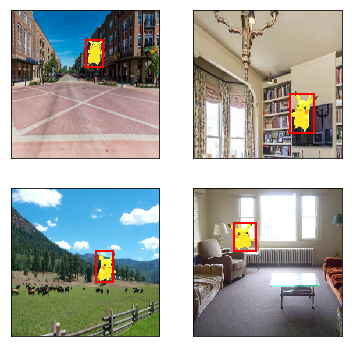

In [9]:
show_bounding_box_images(batch=batch, nrows=2, ncols=2, data_shape=256, figsize=(6, 6))

## <font color="red">SSD Model

### 生成锚框

In [10]:
from mxnet.contrib.ndarray import MultiBoxPrior

sizes = [.5, .25, .1]
ratios = [1, 2, .5]
n = 40
sample = nd.random.normal(shape=(1, 3, n, n))
anchor_boxes = MultiBoxPrior(sample, sizes=sizes, ratios=ratios)
print(anchor_boxes) # 40 X 40 X 5


[[[-0.2375     -0.2375      0.2625      0.2625    ]
  [-0.1125     -0.1125      0.1375      0.1375    ]
  [-0.0375     -0.0375      0.0625      0.0625    ]
  ...
  [ 0.9375      0.9375      1.0375      1.0375    ]
  [ 0.63394666  0.8107233   1.3410534   1.1642767 ]
  [ 0.8107233   0.63394666  1.1642767   1.3410534 ]]]
<NDArray 1x8000x4 @cpu(0)>


In [11]:
boxes = anchor_boxes.reshape((n, n, -1, 4))
boxes[20, 20, :, :]


[[0.2625     0.2625     0.7625     0.7625    ]
 [0.3875     0.3875     0.6375     0.6375    ]
 [0.46249998 0.46249998 0.5625     0.5625    ]
 [0.1589466  0.33572328 0.86605334 0.6892767 ]
 [0.33572328 0.1589466  0.6892767  0.86605334]]
<NDArray 5x4 @cpu(0)>

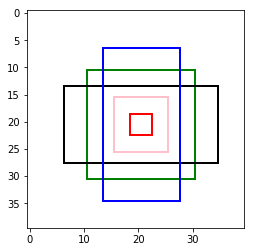

In [12]:
# draw all the anchor boxes which center is (20, 20)
colors = ['green', 'pink', 'red', 'black', 'blue']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rec(anchors[i] * n, colors[i], linewidth=2))

### 边框预测模块

In [13]:
def box_predictor(num_anchor_per_pixel):
    # each pixel on the fm will generate n anchors, and each anchor have 4 coordinates 
    return gluon.nn.Conv2D(int(num_anchor_per_pixel * 4), kernel_size=3, padding=1)

### 类别预测模块

In [14]:
def class_predictor(num_anchor_per_pixel, num_classes):
    # each pixel on the fm will generate n anchors, and each anchor will be responsible
    return gluon.nn.Conv2D(int(num_anchor_per_pixel * (num_classes + 1)), kernel_size=3, padding=1)

### 减半模块

In [15]:
def down_sample(num_filters):
    module = gluon.nn.HybridSequential()
    with module.name_scope():
        for _ in range(2):
            module.add(
                gluon.nn.Conv2D(num_filters, kernel_size=3, padding=1),
                gluon.nn.BatchNorm(axis=1, epsilon=2e-5),
                gluon.nn.Activation('relu')
            )

        # through max pooling to downsample 
        module.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    return module

### 多尺度融合模块

In [16]:
# 尺度变化
sample = nd.zeros(shape=(1, 3, 256, 256))
cls_pred1 = class_predictor(num_anchor_per_pixel=5, num_classes=10)
cls_pred1.initialize()
y1 = cls_pred1(sample)
print("Scale 1 Output:", y1.shape)

downsample = down_sample(num_filters=10)
downsample.initialize()
sample = downsample(sample)
print("Down sample:", sample.shape)

cls_pred2 = class_predictor(num_anchor_per_pixel=3, num_classes=10)
cls_pred2.initialize()
y2 = cls_pred2(sample)
print("Scale 2 Output:", y2.shape)
# 可以看到不同尺度每次预测后的结果都不一样，因此我们定义多尺度融合模块，将不同尺度的输出融合到一起

Scale 1 Output: (1, 55, 256, 256)
Down sample: (1, 10, 128, 128)
Scale 2 Output: (1, 33, 128, 128)


In [17]:
# we define multi-fusion module to fuse different scale together 
def flatten_preds(preds):
    return preds.transpose((0, 2, 3, 1)).flatten()

def concat_preds(preds):
    return nd.concat(*preds, dim=1) # two dimension 

### 特征提取网络

In [18]:
def body_net():
    body = gluon.nn.HybridSequential()
    with body.name_scope():
        for nfilter in [16, 32, 64]:
            body.add(down_sample(num_filters=nfilter))
    return body

### 构建主体网络
* One feature extractor Network
* Three down sample Module 
* five cls predictions 
* five bbox predictions 

In [55]:
def ssd_model(num_anchors_per_pixel, num_classes):
    down_samples = gluon.nn.Sequential()
    class_predictors = gluon.nn.Sequential()
    box_predictors = gluon.nn.Sequential()
    
    # add downsample module 
    for _ in range(3):
        down_samples.add(down_sample(128))
    
    # add class and bbox prediction module  
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors_per_pixel, num_classes))
        box_predictors.add(box_predictor(num_anchors_per_pixel))
        
    ssd_model = gluon.nn.Sequential()
    with ssd_model.name_scope():
        ssd_model.add(body_net(), down_samples, class_predictors, box_predictors)
    return ssd_model

def ssd_model(num_anchors_per_pixel, num_classes):
    down_samples = gluon.nn.Sequential()
    class_predictors = gluon.nn.Sequential()
    box_predictors = gluon.nn.Sequential()
    
    for _ in range(3):
        down_samples.add(down_sample(128))
        
    # add cls and bbox prediction module 
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors_per_pixel, num_classes))
        box_predictors.add(box_predictor(num_anchors_per_pixel))
        
    ssd_model = gluon.nn.H

### 构建前向函数

In [63]:
def ssd_forward(X, ssd_model, sizes, ratios, verbose):
    body_net, down_samples, class_predictors, box_predictors = ssd_model
    
    # prepare for concat
    anchors, class_preds, box_preds = [], [], []
    
    # feature extraction
    X = body_net(X)
    
    # cls + loc predictions and downsample
    for i in range(5):
        anchors.append(MultiBoxPrior(X, sizes=sizes[i], ratios=ratios[i]))
        
        class_preds.append(flatten_preds(class_predictors[i](X)))
        box_preds.append(flatten_preds(box_predictors[i](X)))
        
        # debug
        if verbose:
            # anchors[-1].shape[1] represent the lastest generated anchor nums 
            print("Predict scale", i, ", Ratio:", i, ", Output Shape:", X.shape, ", With", anchors[-1].shape[1], "anchors")
            
        # down_sample
        if i < 3:
            X = down_samples[i](X)
        elif i == 3:
            X = nd.Pooling(X, global_pool=True, pool_type="max", kernel=(X.shape[2], X.shape[3]))
            
    # concat features from different layers 
    return (concat_preds(anchors), concat_preds(class_preds), concat_preds(box_preds))

### 构建SSD模型

In [64]:
class SSD(gluon.nn.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes
        self.verbose = verbose
        
        num_anchors_per_pixel = len(self.anchor_sizes[0]) + len(self.anchor_ratios[0]) - 1 # 
        
        with self.name_scope():
            self.model = ssd_model(num_anchors_per_pixel, num_classes)
            
    def forward(self, X):
        anchors, class_preds, box_preds = ssd_forward(X, self.model, self.anchor_sizes, 
                                                      self.anchor_ratios, self.verbose)
        
        # recover to shape=(batch_size, num_anchor_per_pixel, num_classes+1)
        class_preds = class_preds.reshape(shape=(0, -1, int(self.num_classes+1)))
        
        return anchors, class_preds, box_preds

In [65]:
## 测试SSD模型
ssd_net = SSD(num_classes=1, verbose=True)
ssd_net.initialize()

In [66]:
data = batch.data[0]
anchors, class_preds, box_preds = ssd_net(data)
print("Out anchors : ", anchors.shape)
print("class preds : ", class_preds.shape)
print("box preds : ", box_preds.shape)
### 可以看到输出的anchors无论batch_size是多少最后结果的第一个维度都是1

Predict scale 0 , Ratio: 0 , Output Shape: (4, 64, 32, 32) , With 4096 anchors
Predict scale 1 , Ratio: 1 , Output Shape: (4, 128, 16, 16) , With 1024 anchors
Predict scale 2 , Ratio: 2 , Output Shape: (4, 128, 8, 8) , With 256 anchors
Predict scale 3 , Ratio: 3 , Output Shape: (4, 128, 4, 4) , With 64 anchors
Predict scale 4 , Ratio: 4 , Output Shape: (4, 128, 1, 1) , With 4 anchors
Out anchors :  (1, 5444, 4)
class preds :  (4, 5444, 2)
box preds :  (4, 21776)


### 损失和评估函数

### Focal Loss

In [72]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        '''
        Parameters:
        ----------------
        axis : int
            specify thr axis that compute the mean value (the last axis)
        alpha : float
            scale factor
        gamma : float
            scale factor
        batch_axis : int 
            batch_size axis
        '''
        super().__init__(weight=None, batch_axis=batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma 
        self._batch_axis = batch_axis
        
    def hybrid_forward(self, F, preds, labels):
        '''
        preds : NDArray 
            指类别预测模块输出的预测比例，即ssd_net输出的class_preds shape=(batch_size, num_anchors_per_pixel, num_classes+1)
        labels : NDArray
            注意：指MultiboxTarget输出的label真实标签，即box_target，而非原始的从idx文件中的标签
        '''
        preds = F.softmax(preds) # e,g. output shape = (1, 5444, 2)
        pj = F.pick(data=preds, index=labels, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj)**self._gamma) *  pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)

In [73]:
cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

### Smooth LI Loss
* 平滑的L1损失函数，对误分类较大边框样本的惩罚较小（L2系列的乘法较大，因此不用）， 用于边框偏移量预测模块box_predictors
* 我们利用mask只计算具有真实边框（即IOU>threshold）的锚框的损失， 负例锚框不做考虑
* box_mask skip掉了一些我们不想学的bounding box

In [75]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super().__init__(weight=None, batch_axis=batch_axis, **kwargs)
        self._batch_axis = batch_axis
        
    def hybrid_forward(self, F, preds, labels, mask):
        '''
        preds : 边框预测模块输出的预测值， 属于预测值
        labels: 锚框与真实边框之间的偏移量，属于真实值
        mask : 用于屏蔽不需要的锚框的掩码
        '''
        
        loss = F.smooth_l1((preds - labels) * mask, scalar=1.0) 
        return loss.mean(axis=self._batch_axis, exclude=True)

### 训练

### 测试